## Прогнозирование стоимости квартиры в г. Москва

Задачи:

- сформировать датасет путем парсинга объявлений о продаже жилой недвижимости в г. Москва с сайта Циан;
- проанализировать эти данные и выделить фичи для последующего построения и обучения модели;
- построить эффективную ML модель, оценить влияние отдельных факторов на итоговый результат, определить перспективы дальнейшего развития модели.

Этапы выполнения анализа:

1. Парсинг данных
2. Предобработка данных и EDA
3. Построение ML модели
4. Выводы

## 1. Парсинг данных

In [14]:
# pip install selenium

In [10]:
# pip install catboost

In [8]:
# pip install phik

In [13]:
# импортируем необходимые библиотеки

from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.keys import Keys

import pandas as pd
import numpy as np
import seaborn as sns

import phik
from phik import resources, report
import time
from datetime import date

from catboost import CatBoostRegressor
from catboost import Pool

import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [7]:
# для корректного парсинга с Циана требуется разбить Москву по округам; ссылки сохраняем в словарь

area_raw_links = {
    'СЗАО':'https://www.cian.ru/kupit-kvartiru-vtorichka-moskva-szao-041/',
    'САО':'https://www.cian.ru/kupit-kvartiru-vtorichka-moskva-sao-045/',
    'СВАО':'https://www.cian.ru/kupit-kvartiru-vtorichka-moskva-svao-046/',
    'ЗАО':'https://www.cian.ru/kupit-kvartiru-vtorichka-moskva-zao-0411/',
    'ЦАО':'https://www.cian.ru/kupit-kvartiru-vtorichka-moskva-cao-044/',
    'ВАО':'https://www.cian.ru/kupit-kvartiru-vtorichka-moskva-vao-047/',
    'ЮЗАО':'https://www.cian.ru/kupit-kvartiru-vtorichka-moskva-yuzao-0410/',
    'ЮАО':'https://www.cian.ru/kupit-kvartiru-vtorichka-moskva-yuao-049/',
    'ЮВАО':'https://www.cian.ru/kupit-kvartiru-vtorichka-moskva-yuvao-048/',
    'ЗелАО':'https://www.cian.ru/kupit-kvartiru-vtorichka-moskva-zelenogradskiy-04151/'
             }

In [8]:
# вычисляем номера, которыми в ссылках кодируются округа, и формируем словарь на их основе

area_nums = {
    'СЗАО':'1',
    'САО':'5',
    'СВАО':'6',
    'ЗАО':'11',
    'ЦАО':'4',
    'ВАО':'7',
    'ЮЗАО':'10',
    'ЮАО':'9',
    'ЮВАО':'8',
    'ЗелАО':'151'
             }

In [ ]:
# проверяем качество ссылок

driver = webdriver.Chrome()
for i in area_nums.values():
    l = 'https://www.cian.ru/cat.php?deal_type=sale&district%5B0%5D='+i+\
'&engine_version=2&maxtarea=50&object_type%5B0%5D=1&offer_type=flat'
    try:
        dr = driver.get(l)
        time.sleep(3)
    except:
        print(i)
driver.quit()

In [ ]:
# формируем список данных (показателей), которые необходимо считать для каждого объявления

columns = ['project', 'metro', 'distance_to_metro', 'adress', 'title', 'ready_main', 'room_type', 'square', \
           'floor', \
           'tag_info', 'gallery_tag', 'price', 'price_per_metre', 'seller_type', 'seller_name', 'date', 'time', 'href']

columns_district = ['district']+columns

'''
Специфика парсинга с Циана такова, что предельное количество лотов, выводимых по одному запросу - 1500 шт. (54 стр).
Соотвественно, внутри разбиения по округам, запрос необходимо разбивать еще по нескольким параметрам (фильтрам),
чтобы в итоге количество результатов на выдаче на каждом этапе не превышало 1500, и не происходило потери информации.
Самое оптимальное разбиение - по метражу. Следует учитывать, что в ЦАО высокая концентрация квартир с большой площадью.
'''

square_list = [0, 20, 30, 35, 40, 45, 50, 55, 60, 70, 80, 90, 100, 120, 140, 170, 210, 250, 5000]

# формируем заготовку под итоговый датасет и начниаем процесс парсинга

total_df = pd.DataFrame(columns=columns_district)

total = 0
last_page=False
total_amount = 0

today = date.today()

driver = webdriver.Chrome()

# парсинг идет по округам, а внутри округа - по интервалам метража
for area_name, area_num in list(area_nums.items()):

    print('парсим', area_name)
    print()

    main_df = pd.DataFrame(columns=columns)

    for i, j in enumerate(square_list[:-1]):

        my_min = str(j)
        my_max = str(square_list[i+1])

        flag = 'go'
        count_pages = 0
        filter_df = pd.DataFrame(columns=columns)

        link = 'https://www.cian.ru/cat.php?deal_type=sale&district%5B0%5D='+area_num+\
        '&engine_version=2&maxtarea='+my_max+'&mintarea='+my_min+\
        '&object_type%5B0%5D=1&offer_type=flat&sort=area_order'

        dr = driver.get(link)
        driver.maximize_window()
        time.sleep(3)

        html = driver.page_source
        soup = BeautifulSoup(html, 'lxml')

        if len(soup.find_all(attrs={"data-name":"SummaryHeader"}))<=0:
            print('видимо, пустая страница?', area_name, i, j)

        else:
            amount = soup.find_all(attrs={"data-name":"SummaryHeader"})[0].text
            num = amount.split('Найдено')[-1].split('объявлени')[0].strip()
            num_int = int(''.join(num.split()))

            print(f'в {area_name} на метраже {my_min}-{my_max} нашлось {num_int} лотов')

#             необходимо следить за количеством лотов на фильтре, чтобы оно не превышало 1500

            if num_int>1400:
                print('TW!')

            amount_of_pages = None
            last_page_ads = None

            '''
            После того, как установлен фильтр и сформирована ссылка для парсинга, начинаем снимать результаты постранично.
            Пока для переменной flag сохраняется значение 'go', это означает, что обработаны еще не все доступные страницы.
            Когда устанавливается значение 'stop', это значит, что была обработана последняя страница, и можно переходить к следующему.
            '''

            while flag=='go':

                time.sleep(1)
                html = driver.page_source
                soup = BeautifulSoup(html, 'lxml')

                page_df = pd.DataFrame(columns=columns)

                ad_list = soup.find_all(attrs={"data-testid":"offer-card"})

#                 определяем, является ли текущая страница последней
                if len(soup.find_all(attrs={"data-name":"PreInfiniteBanner"}))>0:
                    ad_list = soup.find_all(attrs={"class":"_93444fe79c--wrapper--W0WqH"})[0].\
                                find_all(attrs={"data-testid":"offer-card"})
                    last_page=True

#                производим парсинг текущей страницы циклом по каждому объявлению
                for ad in ad_list:

                    block_list = ad.find_all(attrs={"data-name":"GeneralInfoSectionRowComponent"})
                    blocks_amount = len(block_list)

                    block_description = []
                    block_tags = []

#                     разбиваем soup конкретного объявления на структурные блоки

                    for i in block_list:
                        if len(i.find_all(attrs={'data-mark':'OfferTitle'}))>0:
                            block_title = i.find_all(attrs={'data-mark':'OfferTitle'})[0].text
                            if len(i.find_all(attrs={'data-mark':'OfferSubtitle'}))>0:
                                block_title = block_title + '; ' + i.find_all(attrs={'data-mark':'OfferSubtitle'})[0].text
                        elif len(i.find_all(attrs={"data-name":"SpecialGeo"}))>0:
                            block_location = i
                        elif len(i.find_all(attrs={"data-mark":"MainPrice"}))>0:
                            block_price = i
                        elif len(i.find_all(attrs={"data-name":"Description"}))>0:
                            block_description = i.find_all(attrs={"data-name":"Description"})
                        elif block_list.index(i) == 1:
                            block_tags = i.find_all('div', '_93444fe79c--label--G5hpt')
                        else:
                            pass

#                     устанавливаем значения None для всех параметров
                    gallery_tag, tag_info, ready_main, floor, room_type, square, project, metro, distance_to_metro,\
                    adress, ready, \
                    description, price, price_int, price_per_metre, price_per_metre_int, seller_info, \
                    seller_type, seller_name, \
                    pub_datetime, pub_date, pub_time = [None]*22

#                     выделяем тэги объявления

                    if len(ad.find_all(attrs={"data-name":"GalleryLabels"}))>0:
                        gallery_tag = ad.find_all(attrs={"data-name":"GalleryLabels"})[0].text

                    if len(block_tags)>0:
                        tag_info = ', '.join([k.text for k in block_tags])

#                     определяем срок сдачи главного корпуса проекта

                    if len(ad.find_all(attrs={"data-mark":"Deadline"}))>0:
                        ready_main = ad.find_all(attrs={"data-mark":"Deadline"})[0].text

#                     выделяем ссылку на страницу предложения

                    href = ad.find('a')['href']

#                     выделяем этаж и комнатность

                    for l in block_title.lower().split(','):
                        if 'этаж' in l:
                                floor = l.strip().split()[0]
                        elif 'комн' in l or 'студ' in l:
                                room_type = l

#                     определяем срок сдачи корпуса

                    ind = block_title.lower().find('сдача корпуса')
                    ready = block_title.lower()[ind+13:].strip()

#                     выделяем площадь квартиры
                    if 'м²' in block_title:
                        try:
                            square = float(block_title.split(' м²')[0].split()[-1].replace(',', '.'))
                        except:
                            if 'м²,' in block_title:
                                try:
                                    square = float(block_title.split(' м²,')[0].split()[-1].replace(',', '.'))
                                except:
                                    square = 0
                    else:
                        square = 0

#                      по возможности, выделяем название проекта (жилого комплекса)

                    if len(block_location.find_all(attrs={"data-name":"ContentRow"}))>0:
                        project = block_location.find_all(attrs={"data-name":"ContentRow"})[0].text

#                     выделяем название ближайшего метро и расстояние до него, а также адрес предложения

                    metro = block_location.find_all(attrs={"data-name":"SpecialGeo"})[0].find_all('a')[0].text
                    distance_to_metro = block_location.find_all(attrs={"data-name":"SpecialGeo"})[0].find_all('div')[-1].text
                    adress = ', '.join([i.text for i in block_location.find_all(attrs={"data-name":"GeoLabel"})])

#                     выявляем цену лота и цену квадратного метра

                    price = block_price.find_all(attrs={"data-mark":"MainPrice"})[0].text.strip('₽')
                    price_int = int(''.join(price.split()))
                    price_per_metre = block_price.find_all(attrs={"data-mark":"PriceInfo"})[0].text.strip('₽/м²')
                    price_per_metre_int = int(''.join(price_per_metre.split()))

#                     выделяем описание объекта

                    if len(block_description)>0:
                        description = block_description[0].text

#                     выделяем данные о продавце

                    seller_info = ad.find_all(attrs={"data-name":"LinkArea"})[-1].\
                                    find_all(attrs={"data-name":"BrandingLevelWrapper"})[0].\
                                    find_all('span')
                    seller_type = seller_info[1].text
                    seller_name = seller_info[2].text

#                     определяем дату и время публикации объявления

                    pub_datetime = ad.find_all(attrs={"data-name":"TimeLabel"})[0].find_all('span')[-1].text
                    pub_date = pub_datetime.split(',')[0]
                    pub_time = pub_datetime.split()[-1]
                    if pub_date=='сегодня':
                        pub_date = str(today)

        #             сохраняем результат в датафрейм
                    my_ad = {'project':project, 'metro':metro, 'distance_to_metro':distance_to_metro, 'adress':adress, \
                             'title':block_title, 'ready':ready, 'ready_main':ready_main,\
                             'description': description,
                             'room_type':room_type, 'square':square, 'floor':floor, 'tag_info':tag_info, \
                             'gallery_tag':gallery_tag,\
                             'price':price_int, 'price_per_metre':price_per_metre_int, \
                             'seller_type':seller_type, 'seller_name':seller_name, 'date':pub_date, 'time':pub_time, \
                             'href':href}

                    my_df = pd.DataFrame(my_ad, index=[None])

#                     добавляем результат по конкретному объявлению в общий датафрейм для конкретной страницы
                    page_df = page_df.merge(my_df, 'outer')

#                добавляем результат по конкретной странице в общий датафрейм по фильтру
                filter_df = filter_df.merge(page_df, 'outer')

                count_pages +=1
                print(f'{count_pages} страница готова ({page_df.shape[0]} лотов)')

                # на одной странице Циан обычно выводит 28 объявлений, но их может быть и меньше


                if last_page:
                    if len(soup.find_all(attrs={"data-name":"Pagination"}))>0:
                        amount_of_pages = soup.find_all(attrs={"data-name":"Pagination"})[0].find_all('li')[-1].text
                    else:
                        amount_of_pages = 1

                    last_page_ads = page_df.shape[0]
                '''
                Проверяем, присутствует ли в панели навигации по страницам кнопка "Дальше".
                Если да, то кликаем на нее. Если нет, то определяем текущую страницу как последнюю (flag='stop') и выходим из цикла.
                '''

                if len(driver.find_elements(By.LINK_TEXT, "Дальше"))>0:
                    button = driver.find_element(By.LINK_TEXT, "Дальше")
                    clicked=False

                    action = ActionChains(driver)
                    action.scroll_to_element(button).send_keys(Keys.ARROW_DOWN).perform()
                    time.sleep(1)
                    action.send_keys(Keys.ARROW_DOWN).send_keys(Keys.ARROW_DOWN).perform()
                    time.sleep(1)

                    count_try = 0

                    while clicked==False:
                        count_try+=1
                        try:
                            button.click()
                            clicked=True
                            time.sleep(3)
                        except:
                            action.send_keys(Keys.ARROW_DOWN).send_keys(Keys.ARROW_DOWN).perform()
                            time.sleep(1)
                else:
                        flag='stop'

#             определяем количество дублирований лотов по уникальным ссылкам

            href_amount = list(main_df['href'].unique()) + list(filter_df['href'].unique())
            unique_href = len(set(href_amount))

#             добавляем результат по фильтру в общий датафрейм по округу
            main_df = main_df.merge(filter_df, 'outer')

            print()
            print(f'итого, с фильтра спарсилось {filter_df.shape[0]} ({count_pages} страниц)')
            print('всего с округа - ', main_df.shape[0], ' лотов')

#     добавляем результат по округу в общий датафрейм по всей Москве
    main_df['district'] = area_name
    total_df = total_df.merge(main_df, 'outer')

    print('итого лотов', total_df.shape[0])

# выходим
driver.quit()

In [ ]:
# делаем бэкап
df_backup = total_df

## 2. Предобработка данных

In [16]:
total_df = pd.read_excel('parsing_240424_msk.xlsx', index_col=[0])

In [17]:
total_df.head(3)

,project,metro,distance_to_metro,adress,title,ready,ready_main,description,room_type,square,...,tag_info,gallery_tag,price,price_per_metre,seller_type,seller_name,date,time,href,district
0,NaN,Пятницкое шоссе,13 минут пешком,"Москва, СЗАО, р-н Митино, м. Пятницкое шоссе, ...","Студия, 20 м², 17/19 этаж","², 17/19 этаж",NaN,ИНТЕРЕСНОЕ ПРЕДЛОЖЕНИЕ!\nПpoдаётся пo переусту...,студия,20.00,...,NaN,NaN,7500000,375000,Агентство недвижимости,Самолет Плюс Москва,вчера,16:25,https://www.cian.ru/sale/flat/300877788/,СЗАО
1,NaN,Тушинская,6 минут пешком,"Москва, СЗАО, р-н Покровское-Стрешнево, м. Туш...","1-комн. апартаменты, 19,7 м², 1/4 этаж","таменты, 19,7 м², 1/4 этаж",NaN,Апартаменты в доме от собственника после полно...,1-комн. апартаменты,19.70,...,NaN,NaN,6880000,349239,Собственник,ID 23840733,11 апр,21:06,https://www.cian.ru/sale/flat/300708864/,СЗАО
2,ЖК «Апарт-комплекс Движение.Тушино»,Спартак,6 минут пешком,"Москва, СЗАО, р-н Покровское-Стрешнево, м. Спа...","Апартаменты-студия, 19,12 м², 20/22 этаж","студия, 19,12 м², 20/22 этаж",NaN,"м. Cпaртaк, м. Тушинcкая (3 минуты пешком). ЖК...",апартаменты-студия,19.12,...,Хорошая цена,NaN,7150000,373954,Риелтор,Виктор Рязанцев,вчера,07:36,https://www.cian.ru/sale/flat/298910674/,СЗАО


In [18]:
total_df.shape

(47594, 21)

In [19]:
# удаляем дубли (одинаковые ссылки)
total_df = total_df.drop_duplicates('href')

In [20]:
# оцениваем объем собранной экспозиции
total_df.shape[0]

47496

In [21]:
# оцениваем распределение количества лотов по округам
total_df['district'].value_counts(dropna=False)

district
ЦАО      8373
ЗАО      7395
САО      5246
ЮАО      4910
ЮВАО     4515
ЮЗАО     4400
СВАО     4140
ВАО      4005
СЗАО     3929
ЗелАО     583
Name: count, dtype: int64

In [22]:
# оцениваем процентное распределение экспозиции по округам
total_df['district'].value_counts(dropna=False, normalize=True)

district
ЦАО      0.176289
ЗАО      0.155697
САО      0.110451
ЮАО      0.103377
ЮВАО     0.095061
ЮЗАО     0.092639
СВАО     0.087165
ВАО      0.084323
СЗАО     0.082723
ЗелАО    0.012275
Name: proportion, dtype: float64

In [23]:
# удаляем из выгрузки доли и частные дома
ind_del = []
count = 0
for i in total_df[total_df['description'].isna()==False]['description'].to_list():
    if 'доля' in i.lower() and ('не доля' not in i.lower() and 'в равных долях' not in i.lower() and \
        'наделены долями' not in i.lower() and 'доля в праве' not in i.lower() and 'по документам-доля' not in i.lower() and \
        'доля в общем числе' not in i.lower() and 'прилагается доля' not in i.lower() and 'доля продается вместе с квартирой' \
        not in i.lower() and 'по документам проходит как доля' not in i.lower() and 'по документам доля' not in i.lower() and \
        'реализуется как доля' not in i.lower() and 'доля нежилого помещения' not in i.lower() and 'доля по документам' \
                               not in i.lower()):

            ind = total_df[total_df['description']==i].index.to_list()
            ind_del+=ind

            count+=1

for i in total_df[total_df['description'].isna()==False]['description'].to_list():
    for tw in ['торги', 'аукцион', 'печное', 'деревянный дом', 'туалет на улице']:
        if tw in i.lower() and 'не торги' not in i.lower() and 'не аукцион' not in i.lower() and 'аукциона нет' \
                not in i.lower() and 'куплены на аукционе' not in i.lower() and 'торг уместен' not in i.lower() and \
                'на аукционах' not in i.lower():

            ind = total_df[total_df['description']==i].index.to_list()
            ind_del+=ind

            count+=1

total_df = total_df.drop(list(set(ind_del)))
total_df = total_df.reset_index()

# в целях предосторожности, добавляем второй бэкап
df_backup_2 = total_df

In [24]:
total_df.shape

(47207, 22)

In [25]:
# вручную корректируем несчитавшиеся площади (либо удаляем их)
total_df[total_df['square']==0]

,index,project,metro,distance_to_metro,adress,title,ready,ready_main,description,room_type,...,tag_info,gallery_tag,price,price_per_metre,seller_type,seller_name,date,time,href,district


In [26]:
'''
набор функций для обработки данных, полученных в результате парсинга
функция принимает значение столбца адрем ('adress') и возвращает название района ('area')
'''
def find_the_area(x):
    if 'район' in x:
        for i in x.split(','):
            if 'район' in i:
                return ''.join(i.split('район')).strip()
    if 'р-н' in x:
        for i in x.split(','):
            if 'р-н' in i:
                return 'р-н '+''.join(i.split('р-н')).strip()
    if 'мкр' in x:
        for i in x.split(','):
            if 'мкр' in i:
                return ''.join(i.split('мкр')).strip().strip('.').strip()

'''
функция принимает значение столбца заголовка ('title') и возвращает срок сдачи корпуса ('ready')
'''

def find_the_stadium(x):
    x = x.lower()
    if 'сдача корпуса' in x:
        ind = x.find('сдача корпуса')
        return x[ind+13:].strip()
    if 'сдан' in x:
        return 'сдан'

'''
функция принимает значение столбца заголовка ('title') и возвращает комнатность лота ('room_type')
'''

def find_the_roomtype(x):
    x = x.lower()
    for i in ['1-комн. квартира', '2-комн. квартира', '3-комн. квартира', '4-комн. квартира', '5-комн. квартира', \
              '6-комн. квартира', 'студия', '1-комн. апартаменты', '2-комн. апартаменты', '3-комн. апартаменты', \
              '4-комн. апартаменты', '5-комн. апартаменты', '6-комн. апартаменты',\
              'своб. планировка']:
        if i in x:
            return i

'''
функция принимает значение столбца комнатности ('room_type') и возвращает его в числовом формате (int)
'''

def find_the_roomtype_int(x):
    x = x.lower()
    if 'студия' in x:
        return 'студия'
    if '1-комн' in x:
        return 1
    if '2-комн' in x:
        return 2
    if 'своб. планировка' in x:
        return 'своб. планировка'
    if '3-комн' in x:
        return 3
    if '4-комн' in x:
        return 4

'''
функция принимает значение столбца заголовка ('title') и возвращает номер (название) секции ('section')
'''

def find_the_section(x):
    if 'Секция Секция' in x:
        ind = x.find('Секция Секция')
        return x[ind+14]
    elif 'Секция' in x:
        x = x.split()
        for i in x:
            if 'Секция' in i:
                ind = x.index(i)
                return x[ind+1]


In [27]:
# оцениваем распределение типов продавцов
total_df['seller_type'].value_counts(dropna=False)

seller_type
Агентство недвижимости    25333
Риелтор                   13827
Собственник                5250
NaN                        2694
Ук・оф.Представитель          85
Отдел аренды                 18
Name: count, dtype: int64

In [28]:
# стандартизируем типы данных в столбцах

for i in total_df.columns:
  if total_df[i].dtype == 'object':
    total_df.loc[(total_df[i].isna()), i] = 'нет данных'

In [29]:
# определяем (по возможности) тип помещения (апартаменты/квартира), и оцениваем их распределение
total_df['flat_type'] = total_df['description'].map(lambda x:'апартаменты' if 'апартамент' in x.lower() else \
                                                ('квартира' if 'квартир' in x.lower() else 'нет данных'))

total_df.loc[(total_df['flat_type']=='нет данных'), 'flat_type'] = \
total_df.loc[(total_df['flat_type']=='нет данных'), 'title'].map(lambda x:'апартаменты' if 'апартамент' in x.lower() else \
                                                ('квартира' if 'квартир' in x.lower() else 'нет данных'))

total_df['flat_type'].value_counts(dropna=False)

flat_type
квартира       41371
апартаменты     5427
нет данных       409
Name: count, dtype: int64

In [30]:
# определяем типы комнатности и оцениваем их распределение по рынку
total_df['room_type'] = total_df['title'].map(lambda x: find_the_roomtype(x))
total_df['room_type'].value_counts(dropna=False)

room_type
2-комн. квартира       13508
3-комн. квартира       11388
1-комн. квартира        9288
4-комн. квартира        3767
студия                  2609
2-комн. апартаменты     1422
5-комн. квартира        1323
3-комн. апартаменты     1010
1-комн. апартаменты      892
6-комн. квартира         814
своб. планировка         511
4-комн. апартаменты      282
None                     234
5-комн. апартаменты       84
6-комн. апартаменты       75
Name: count, dtype: int64

In [31]:
# типы комнатности, которые не удалось определить, скорее всего являются долями, которое мы удаляем
del_list_2 = total_df[total_df['room_type'].isna()].index.to_list()
total_df = total_df.drop(list(set(del_list_2)))
total_df = total_df.reset_index()

In [32]:
# выделяем для каждого лота секцию, отделку, район, стадию строительной готовности (по возможности)
# также, стоит отдельно выделить номера этажей и типов комнатности в формате int, что более удобно для анализа
total_df['section'] = total_df['title'].map(lambda x:find_the_section(x))
total_df['decor'] = total_df['tag_info'].map(lambda x:'с отделкой' if 'с отделкой' in x.lower() else None)
total_df['area'] = total_df['adress'].map(lambda x:find_the_area(x))
total_df['ready'] = total_df['title'].map(lambda x:find_the_stadium(x))
total_df['room_type_int'] = total_df['title'].map(lambda x:find_the_roomtype_int(x))
total_df['floor_int'] = total_df['floor'].map(lambda x:int(x.split('/')[0]))

In [33]:
# удаляем все лоты, выставленные на электронных торгах и аукционах, т.к. указанная для них цена, скорее всего, нерелевантна
total_df = total_df[total_df['gallery_tag']!='Электронные торги']
total_df = total_df[total_df['gallery_tag']!='Аукцион']

In [34]:
# перезаписываем все тэги в один столбец
total_df.loc[(total_df['gallery_tag'].isna()), 'gallery_tag'] = ''
total_df.loc[(total_df['tag_info'].isna()), 'tag_info'] = ''

total_df['tag'] = total_df['tag_info']+'; '+total_df['gallery_tag']

total_df['tag'] = total_df['tag'].map(lambda x: x.strip().strip(';'))

total_df['tag'].unique()

array(['нет данных; нет данных', 'Хорошая цена; нет данных',
       'Хорошая цена, Проверено в Росреестре; нет данных',
       'Только на Циан; нет данных',
       'Только на Циан, Проверено в Росреестре; нет данных',
       'Хорошая цена, Только на Циан; нет данных',
       'Проверено в Росреестре; нет данных',
       'Хорошая цена, Только на Циан, Проверено в Росреестре; нет данных',
       'Хорошая цена, Только на Циан, Проверено в Росреестре, Аукцион; Электронные торги в коммерции',
       'Только на Циан, Проверено в Росреестре, Аукцион; Электронные торги в коммерции',
       'Хорошая цена; От банка, с обременением',
       'Проверено в Росреестре, Аукцион; нет данных',
       'Хорошая цена, Только на Циан, Аукцион; Электронные торги в коммерции',
       'Аукцион; Электронные торги в коммерции',
       'нет данных; От банка, с обременением', 'Аукцион; нет данных',
       'Хорошая цена, Только на Циан, Двушка той же площади; нет данных',
       'Хорошая цена, Проверено в Росреестре

In [35]:
# переименовываем столбцы
total_df.columns = ['level_0', 'index', 'проект', 'метро', 'время до метро', 'адрес', 'заголовок', \
                    'стадия строительной готовности', \
                    'стадия строительной готовности (главный корпус)', 'описание', 'тип комнатности', 'площадь', \
                    'этаж', 'tag_info', 'gallery_tag', 'цена', 'цена за квадратный метр', 'продавец (тип)', \
                    'продавец (имя)', 'дата публикации объявления', 'время публикации объявления', 'ссылка', 'округ', \
                   'тип помещения', 'секция', 'отделка', 'район', 'тип комнатности (цифрой)', 'этаж (цифрой)', 'особенности']

In [36]:
# пересобираем датасет
total_df = total_df[['округ', 'проект', 'район', 'метро', 'время до метро', 'адрес', 'стадия строительной готовности', \
       'стадия строительной готовности (главный корпус)', 'заголовок', 'описание', 'особенности', 'тип помещения', 'секция', \
        'тип комнатности', 'тип комнатности (цифрой)', 'площадь', 'этаж', 'этаж (цифрой)', 'отделка', \
        'цена', 'цена за квадратный метр', 'продавец (тип)', 'продавец (имя)', \
                         'дата публикации объявления', 'время публикации объявления', 'ссылка']]

In [37]:
total_df = total_df.reset_index()

In [38]:
# сохраняем датасет в формате excel
total_df.to_excel('парсинг_вторичка_Старая Москва.xlsx')

## 3. Построение ML модели


In [39]:
# считываем датасет
df = pd.read_excel('парсинг_вторичка_Старая Москва.xlsx', index_col=[0])

In [40]:
df['время до метро'].value_counts(dropna=False)

время до метро
10 минут пешком            3375
8 минут пешком             3249
7 минут пешком             3117
6 минут пешком             3070
9 минут пешком             2986
12 минут пешком            2728
11 минут пешком            2634
5 минут пешком             2523
13 минут пешком            2108
4 минуты пешком            2076
15 минут пешком            2065
14 минут пешком            1917
5 минут на транспорте      1808
3 минуты пешком            1789
4 минуты на транспорте     1637
16 минут пешком            1444
2 минуты пешком            1386
17 минут пешком            1135
18 минут пешком             993
19 минут пешком             975
6 минут на транспорте       806
20 минут пешком             791
1 минута пешком             617
3 минуты на транспорте      428
7 минут на транспорте       394
8 минут на транспорте       321
9 минут на транспорте       201
10 минут на транспорте      185
11 минут на транспорте       76
2 минуты на транспорте       48
12 минут на транспорте   

In [41]:
# возможно, есть смысл разделить время до метро на цифру и транспорт/пешком
df['время до метро (цифрой)'] = df['время до метро'].map(lambda x:int(x.split()[0]) if (x.split()[0]).isdigit() \
                                                         else 'нет данных')
df['время до метро (способ)'] = df['время до метро'].map(lambda x:'транспорт' if 'на транспорте' in x else \
                                                         ('пешком' if 'пешком' in x else 'нет данных'))
df = df[df['время до метро (цифрой)']!='нет данных']

In [42]:
df['время до метро (цифрой)'].unique()

array([13, 6, 8, 9, 5, 12, 4, 3, 14, 15, 10, 17, 11, 20, 18, 7, 16, 2, 19,
       1, 36, 24, 25, 29, 28, 27, 30, 60, 26, 37, 35, 40], dtype=object)

In [43]:
df['время до метро (способ)'].value_counts(dropna=False)

время до метро (способ)
пешком       40978
транспорт     5992
Name: count, dtype: int64

In [44]:
'''
функция для разбиения расстояния до метро на интервалы
принимает расстояние до метро (количество минут в пути)
возвращает название группы (интервал)
'''
def cut_the_group(x):

  if str(x).isdigit():
    x = int(x)
    for i, j in enumerate(cut_bins[:-1]):
          my_min = j
          my_max = cut_bins[i+1]
          if my_min<x<=my_max:
            return str(my_min)+' - '+str(my_max)
  return 'нет данных'

In [45]:
# разбиваем расстояние до метро на группы

df['время до метро (группа)'] = None

cut_bins = [0, 5, 10, 15, 20, 30, 100]

for way in ['пешком', 'транспорт']:
  df.loc[(df['время до метро (способ)']==way), 'время до метро (группа)'] = \
  df.loc[(df['время до метро (способ)']==way), 'время до метро (цифрой)'].map(lambda x: cut_the_group(x)+' '+way)

In [46]:
# выделяем этажность дома
df['этажность дома'] = df['этаж'].map(lambda x:int(x.split('/')[-1]))

In [109]:
# оцениваем выбросы
q1 = df['цена за квадратный метр'].quantile(0.93)
q2 = df['цена за квадратный метр'].quantile(0.07)

<Axes: ylabel='цена за квадратный метр'>

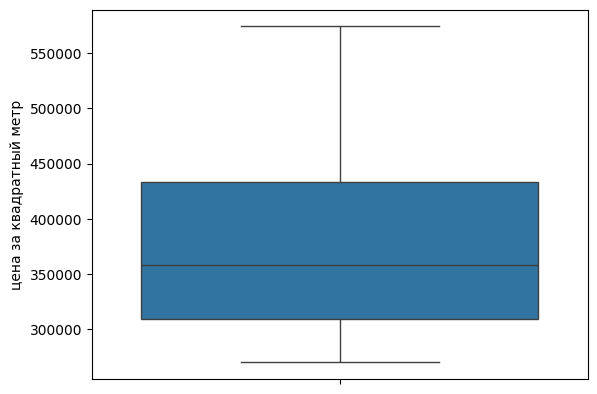

In [110]:
sns.boxplot(df[df['цена за квадратный метр'].between(q2, q1)]['цена за квадратный метр'])

In [97]:
# срезаем выбросы
df = df[df['цена за квадратный метр'].between(q2, q1)]

In [98]:
# определяем таргет и фичи

y = ['цена за квадратный метр']

cat_features = ['метро', 'время до метро (группа)']
num_features = ['этажность дома', 'площадь']

x = cat_features+num_features

In [99]:
# разбиваем датасет на обучающую, тестовую и валидационную выборки

train, test = train_test_split(df, test_size=0.2, random_state=12)
train, val = train_test_split(train, test_size=0.25, random_state=12)

In [100]:
# формируем наборы обучающих и валидационных данных

train_data = Pool(
    data=train[x],
    label = train[y],
    cat_features=cat_features
    )

eval_data = Pool(
    data=val[x],
    label = val[y],
    cat_features=cat_features
    )

In [104]:
# устанавливаем параметры модели

parameters = {'cat_features':cat_features,
              'loss_function':'MAE',
              'eval_metric':'MAE',
              'learning_rate':0.4,
              'early_stopping_rounds':200,
              'random_seed':42,
              'verbose':100}

In [105]:
# обучаем модель

model = CatBoostRegressor(**parameters)
model.fit(train[x], train[y], eval_set=(val[x], val[y]))

0:	learn: 66772.8542975	test: 67488.0507614	best: 67488.0507614 (0)	total: 16.2ms	remaining: 16.2s
100:	learn: 45092.1241361	test: 46871.1688385	best: 46862.6470235 (99)	total: 1.29s	remaining: 11.5s
200:	learn: 42474.4405577	test: 46110.8539139	best: 46110.8539139 (200)	total: 3.29s	remaining: 13.1s
300:	learn: 41216.9291955	test: 46018.7125178	best: 46014.5841504 (287)	total: 5.18s	remaining: 12s
400:	learn: 40447.9735969	test: 45846.6303218	best: 45846.6303218 (400)	total: 7.17s	remaining: 10.7s
500:	learn: 39805.8207657	test: 45715.7904703	best: 45710.6243682 (489)	total: 9.05s	remaining: 9.01s
600:	learn: 39261.4984523	test: 45718.3785566	best: 45700.8397636 (508)	total: 10.3s	remaining: 6.84s
700:	learn: 38789.0268049	test: 45707.3467292	best: 45689.4075245 (684)	total: 11.6s	remaining: 4.93s
800:	learn: 38407.7615440	test: 45729.1991073	best: 45689.4075245 (684)	total: 12.8s	remaining: 3.18s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 45689.40752
bestItera

In [106]:
test['price_pred'] = model.predict(test[x])

In [107]:
# оцениваем эффективность модели на основе метрик MAE и MAPE
mean_absolute_error(test['цена за квадратный метр'], test['price_pred'])

44838.88958058782

In [108]:
mean_absolute_percentage_error(test['цена за квадратный метр'], test['price_pred'])

0.1123984444533071

In [111]:
# оцениваем фичи по коэффициенту Пирсона, feature importance и phik

for i in ['этаж (цифрой)', 'этажность дома', 'площадь']:
  coef = np.corrcoef(df[i], df['цена за квадратный метр'])
  print(i, coef[0][1])

этаж (цифрой) 0.20576906157282
этажность дома 0.3067441292356906
площадь 0.23446427646765072


In [112]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,метро,45.014870
1,этажность дома,24.119900
2,площадь,17.881771
3,время до метро (группа),12.983458


In [113]:
df_phik = df[list(x+y)]
phik_overview = df_phik.phik_matrix()
phik_overview

interval columns not set, guessing: ['этажность дома', 'площадь', 'цена за квадратный метр']


,метро,время до метро (группа),этажность дома,площадь,цена за квадратный метр
метро,1.000000,0.737822,0.800757,0.455201,0.685599
время до метро (группа),0.737822,1.000000,0.150723,0.092527,0.167401
этажность дома,0.800757,0.150723,1.000000,0.235096,0.327013
площадь,0.455201,0.092527,0.235096,1.000000,0.286906
цена за квадратный метр,0.685599,0.167401,0.327013,0.286906,1.000000


<Axes: >

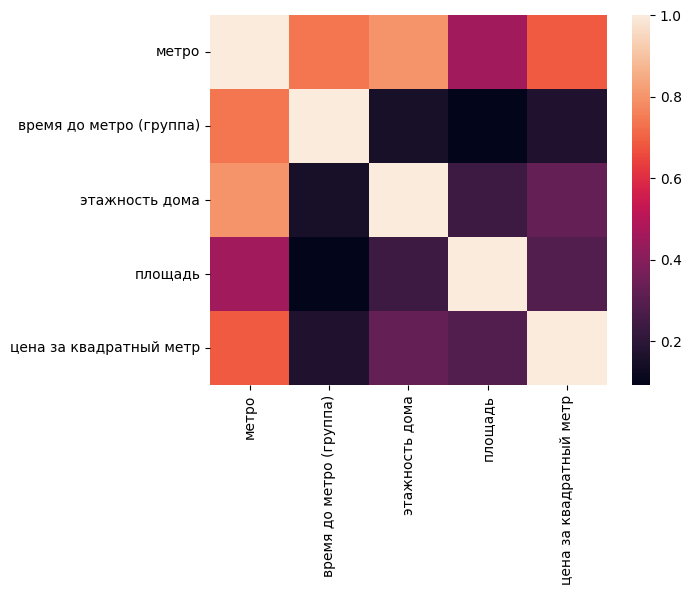

In [114]:
sns.heatmap(phik_overview)

In [115]:
# сохраняем модель
model.save_model('msk_flats_regr')

## 4. Выводы


Таким образом, наибольшее влияние на итоговую цену оказывают такие факторы, как: ближайшая станция метро, площадь квартиры, этажность дома. Построенная модель для прогнозирования цены квадратного метра с показателем MAPE 0.11 считается хорошей. Однако ее можно улучшить и доработать, в т.ч. следующими способами:

- отдельная обработка аномальных значений;
- выстраивание типологии для более корректного разбиения типов комнатности на основе проектов и метража (с выделением евро-форматов);
- поиск и выделение новых фич из уже имеющейся информации, или из сторонних источников (год постройки дома, новостройка/вторичка, застройщик, класс проекта, конкурентное окружение, наличие ремонта, благополучность района, улица, структура спроса в локации, видовая этажность, и т.д.)

Кроме того, можно собирать данные с определенной регулярностью, чтобы отслеживать динамику и получать актуальные прогнозы. Также можно построить отдельную модель классификации для оценки структуры предложения по округам или районам, по типам комнатности, по плотности (распределение количества предложений по локациям), и визуализировать результат (разбиение на ценовые группы) через тепловую карту.